In [84]:
%%capture
#%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2

%reset -f

import os, sys, copy
import numpy as np

import pylab as plt
import matplotlib as mpl
import scipy.io, scipy.signal

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams.update({"axes.grid" : True})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.rcParams.update({'font.size': 14})

In [85]:
from twpazer import vnautils

In [86]:
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

#from matplotlib import cm, colors
#cmap   = plt.cm.turbo_r
#ols   = get_colors(pows, cmap, 
#                    vmin=np.min(pows), vmax=np.max(pows))
#cols   = list(reversed(cols))

#cols   = dict(zip(reversed(pows), cols))

In [148]:
def get_data(matfile, poffset=-32, excluded=None, issmooth=False, iscompensate=False, npts=500):
    
    mat=scipy.io.loadmat(matfile)
    #pows=
    
    
    G      = np.array([])
    Gs     = np.array([])
    pows   = list()
    maxG   = list()
    ripple = list() 
    BW     = list()
    
    for i in range(mat['gainAll'].shape[0]):    
        if excluded and i in excluded:
            continue
        
        
        if iscompensate:
            f, Gtemp, Gstemp = vnautils.compensate_data(mat['f'], mat['gainAll'][i,:], 8.5, 0.5)
        else:
            f      = mat['f']
            Gtemp  = mat['gainAll'][i,:]
        
        
        if not issmooth:
            Gstemp = mat['gainSmoothedAll'][i,:]
        else: 
            Gstemp = scipy.signal.savgol_filter(list(mat['gainSmoothedAll'][i,:]), npts, 3)
        
        if G.size:
            G  = np.vstack((G, Gtemp))
            Gs = np.vstack((Gs,Gstemp))  
        else:
            G  = Gtemp
            Gs = Gstemp
        
        pows.append(mat['pumpPows'][0][i]+poffset)
        maxG.append(np.max(Gstemp))
        
        f1, f2 = vnautils.get_bandwidth(f, Gstemp, 3)
        rstd, rmm = vnautils.estimate_ripple2(f, Gtemp, f1, f2)
        
        #rstd, rmm = vnautils.estimate_ripple(f, Gtemp, 7, 0.5)
        ripple.append(rstd)
        
        #f1, f2 = vnautils.get_bandwidth(f, Gstemp, 3)
        BW.append(f2-f1)
        
    return {'f'     : np.array(mat['f']),
            'G'     : np.array(G),           
            'Gs'    : np.array(Gs),
            'pows'  : np.array(pows), 
            'maxG'  : maxG, 
            'ripple': ripple, 
            'BW'    : BW}

In [263]:
from matplotlib import cm, colors
import matplotlib.gridspec as gridspec  

def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))


def plot_trend(T, res, pathname=None, title=None):
    
    if T not in res:
        return

    cmap   = plt.cm.turbo_r
    cols   = get_colors(res[T]['pows'], 
                        cmap, 
                        vmin=np.min(res[T]['pows']), 
                        vmax=np.max(res[T]['pows']))
    cols   = list(reversed(cols))

        
    fig=plt.figure()
    #plt.subplots_adjust(wspace=0, hspace=0)
    size = plt.gcf().get_size_inches()#*plt.gcf().dpi
    plt.gcf().set_figheight(size[1]*2.2)
    plt.gcf().set_figwidth(size[0])
  
    gs = gridspec.GridSpec(2, 1,  hspace=0.3)

    ax0 = plt.subplot(gs[0])
    
    for i in range(len(res[T]['pows'])):
        
        ax0.plot(res[T]['f'], res[T]['G'][i,:],  alpha=0.4, color=cols[i])
        ax0.plot(res[T]['f'], res[T]['Gs'][i,:], color=ax0.lines[-1].get_color(), zorder=1000)
    
    
    ax0.set_title(title) if title else None
    ax0.set_ylim([-10, 40]) 
    ax0.set_xlabel('Frequency [GHz]')
    ax0.set_ylabel('Gain [dB]')

    ax0.text(0.5, 0.5, 'Preliminary', transform=ax0.transAxes,
             fontsize=70, color='gray', alpha=0.6,
             ha='center', va='center', rotation=30, zorder=1000)
    
    
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.545, 0.025, 0.335])
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(np.min(res[T]['pows']),                                                                                                     
                                                         np.max(res[T]['pows'])), 
                                   cmap=cmap.reversed()), 
                 cax=cbar_ax, 
                 ax=ax0)
    
    cbar_ax.set_ylabel('Pump Generator Power [dBm]')
    
    
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,    
                                             subplot_spec=gs[1], 
                                             wspace=0, hspace=0)
    
    axi0 = plt.Subplot(fig, inner[0])
    
    axi0.plot(res[T]['pows'], res[T]['maxG'], marker='o')
    #axi0.set_xlabel('Pump Generator Power [dBm]')
    axi0.xaxis.set_ticklabels([])
    axi0.set_ylabel('Max Gain\n[dB]')
    axi0.set_title(title) if title else None
    axi0.set_ylim([axi0.get_ylim()[0], 
                   axi0.get_ylim()[1]+0.2*(axi0.get_ylim()[1]-axi0.get_ylim()[0]) ])
    
    print(axi0.get_ylim())
    
    axi1 = plt.Subplot(fig, inner[1])
     
    axi1.plot(res[T]['pows'], res[T]['ripple'], marker='o')
    #axi1.set_xlabel('Pump Generator Power [dBm]')
    axi1.xaxis.set_ticklabels([])
    axi1.set_ylabel('Ripple RMS\n[dB]')
    axi1.set_ylim([axi1.get_ylim()[0], 
                   axi1.get_ylim()[1]+0.2*(axi1.get_ylim()[1]-axi1.get_ylim()[0]) ])
    

    
    
    axi2 = plt.Subplot(fig, inner[2])
     
    axi2.plot(res[T]['pows'], res[T]['BW'], marker='o', zorder=0)
    axi2.set_xlabel('Pump Generator Power [dBm]')
    axi2.set_ylabel('BW\n[GHz]')
    axi2.set_ylim([axi2.get_ylim()[0], 
                   axi2.get_ylim()[1]+0.2*(axi2.get_ylim()[1]-axi2.get_ylim()[0]) ])

    
    
    axi2.text(0.5, 1.5, 'Preliminary', transform=axi2.transAxes,
              fontsize=70, color='gray', alpha=0.6,
              ha='center', va='center', rotation=30, zorder=2000)


    fig.add_subplot(axi0)
    fig.add_subplot(axi1)
    fig.add_subplot(axi2)
    
    if title:
        root, ext = os.path.splitext(title)
        savename = root if ext else title
    else:
        savename='global_gain'
    
    
    if pathname and type(pathname) == str:
        for e in ['.pdf', '.svg']:
            plt.gcf().savefig(os.path.join(pathname,savename+'_{T}mk'.format(T=T)+e),            
                              bbox_inches='tight', transparent=True)
    
    return

/home/giachero/pvenv/dwenv3.8/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


<IPython.core.display.Javascript object>


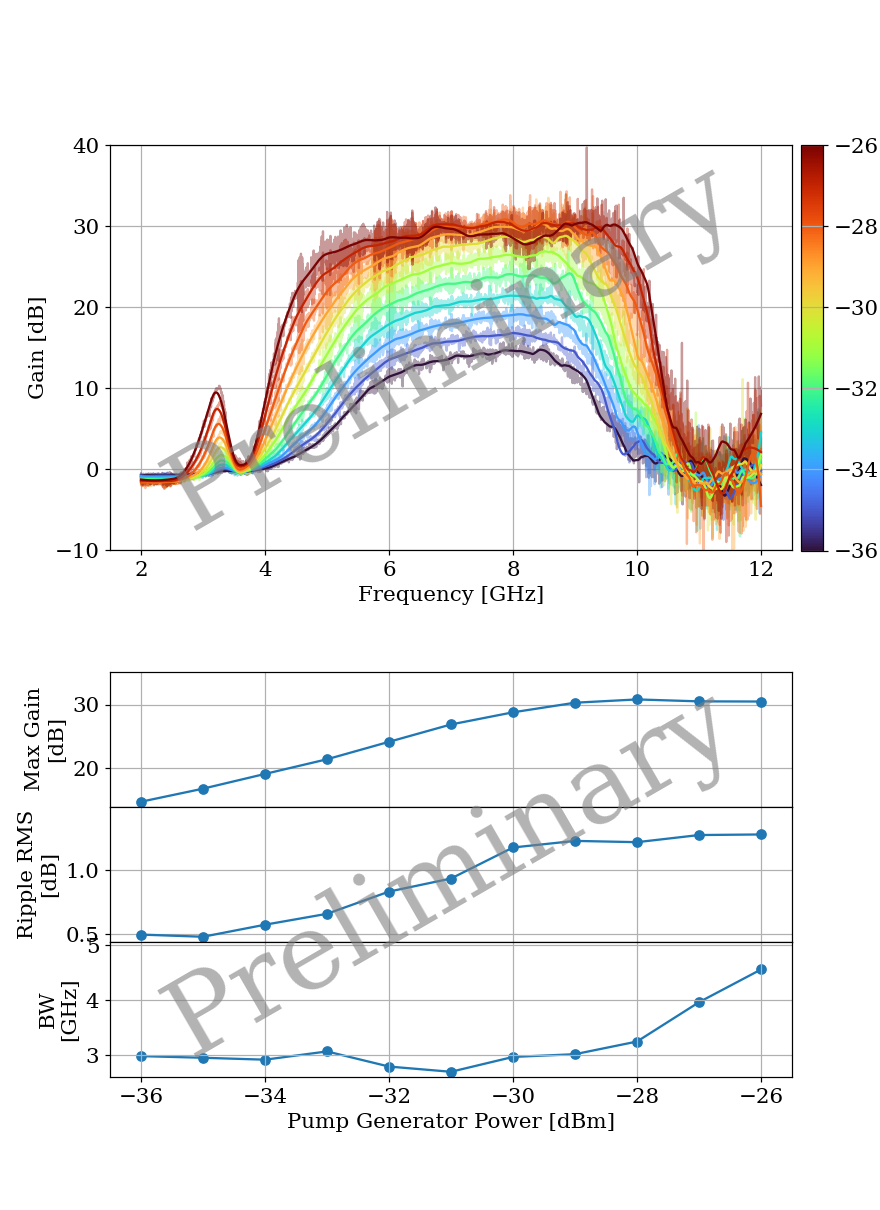

(13.953840645136475, 35.1879237003938)


In [264]:
pathname = '/home/giachero/gsbox/kids_rd/DARTWARS/data/KIT.v3/'
#filename = '20240807_120010_gain_profile_pump_pow_sweep.mat'
filename = '20240807_114510_gain_profile_pump_pow_sweep.mat'


res4={50: get_data(os.path.join(pathname, filename), 
                   excluded=[0,12,13,14,15],
                   issmooth=True,
                   iscompensate=True,
                   npts=100)}

plot_trend(50, res4, pathname)

In [234]:
ii = 10
f = res4[50]['f']
G = res4[50]['G'][ii,:]
Gs = res4[50]['Gs'][ii,:]
P  = res4[50]['pows'][ii]

f1, f2 = vnautils.get_bandwidth(f, Gs, 3)
rstd, rmm = vnautils.estimate_ripple2(f, G, f1, f2)
print(f2-f1)
print(rstd, rmm)

[4.56]
1.2809221490995948 12.885450873084292


<IPython.core.display.Javascript object>


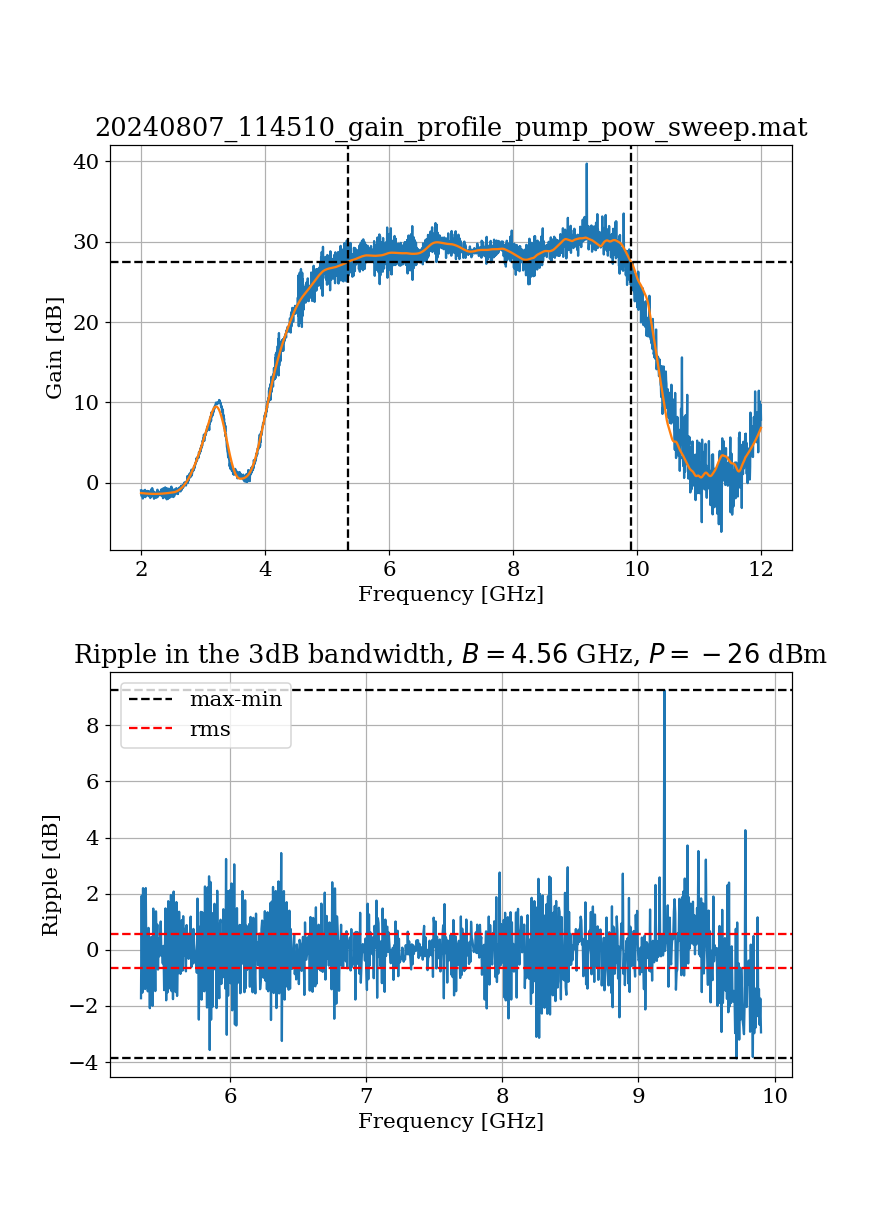

In [225]:
fig, axs = plt.subplots(2)
plt.subplots_adjust(hspace=0.3)
size = plt.gcf().get_size_inches()#*plt.gcf().dpi
plt.gcf().set_figheight(size[1]*2.2)
plt.gcf().set_figwidth(size[0])

axs[0].plot(f,G)
axs[0].plot(f,Gs)

axs[0].axhline(y=np.max(Gs-3), color='k', linestyle='--')
axs[0].axvline(x=f1, color='k', linestyle='--')
axs[0].axvline(x=f2, color='k', linestyle='--')

axs[0].set_xlabel('Frequency [GHz]')
axs[0].set_ylabel('Gain [dB]')
axs[0].set_title(filename)


idmin=vnautils.val2idx(f1, f)
idmax=vnautils.val2idx(f2, f)

fr = f[idmin:idmax]
r  = (G-Gs)[idmin:idmax]

axs[1].plot(fr,r)
axs[1].set_xlabel('Frequency [GHz]')
axs[1].set_ylabel('Ripple [dB]')
axs[1].set_title('Ripple in the 3dB bandwidth, $B={B:0.2f}$ GHz, $P={P}$ dBm'.format(B=(f2-f1)[0],
                                                                               P=P))

(M, m) = (np.max(r), np.min(r))
(rms, avg) = (np.std(r), np.mean(r))  

axs[1].axhline(y=M, color='k', linestyle='--', label='max-min')
axs[1].axhline(y=m, color='k', linestyle='--')

axs[1].axhline(y=avg+rms/2, color='r', linestyle='--', label='rms')
axs[1].axhline(y=avg-rms/2, color='r', linestyle='--')

savename, _ = os.path.splitext(filename)

plt.legend(loc='upper left')

for e in ['.pdf', '.svg']:
    plt.gcf().savefig(os.path.join(pathname,savename+'_ripple_{ii}'.format(ii=ii)+e),                
                      bbox_inches='tight', transparent=True)